# Script Set Up

In [1]:
%matplotlib inline

In [2]:
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 27.5 MB/s eta 0:00:00


In [3]:
!pip install pingouin
import pingouin as pg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7026 sha256=90af50d670f25b97488d20d08178250750cda59c7da635e245fbacc37c0e49d6
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


In [4]:
pip install h5io --upgrade

In [5]:
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import pandas as pd
import seaborn as sns
import mne
import math
from scipy.io import loadmat
from scipy.fft import fft

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Deciding what response times are outliers that should be removed

In [7]:
lower_RT_cutoff = 150
upper_RT_cutoff = 1500 # 1.5x longest SI and is less than 1% of trials

# Load Data

In [8]:
ID_list = ['P1', 'P3', 'P4', 'P7', 'P10', 'P12', 'P15', 'P17', 'P19',
           'P21', 'P22', 'P23', 'P24', 'P26', 'P27', 'P28', 'P29', 'P30']

n_participants = len(ID_list)
n_channels = 128
n_times_encode = 41
n_times_repo = 33
n_times_RL = 33
n_freqs = 1
fs_beta = [8, 30]

sample_rate = 512

encode_epochs = []
encode_metadata = []
repo_epochs = []
repo_metadata = []
RL_epochs = []
RL_metadata = []

all_encode_beta = np.zeros([len(ID_list), n_channels, n_freqs, n_times_encode])
all_repo_beta = np.zeros([len(ID_list), n_channels, n_freqs, n_times_repo])
all_RL_beta = np.zeros([len(ID_list), n_channels, n_freqs, n_times_RL])


for i in range(0, len(ID_list)):
  ID = ID_list[i]
  encode_fname = "/content/drive/MyDrive/Time_Reproduction/Beta_Epochs/" + ID + "_encode_beta_epochs-tfr.h5"
  repo_fname = "/content/drive/MyDrive/Time_Reproduction/Beta_Epochs/" + ID + "_repo_beta_epochs-tfr.h5"
  RL_fname = "/content/drive/MyDrive/Time_Reproduction/Beta_Epochs/" + ID + "_RL_beta_epochs-tfr.h5"

  encode_epochs_participant = mne.time_frequency.read_tfrs(encode_fname)
  encode_epochs_participant = encode_epochs_participant[0]
  repo_epochs_participant = mne.time_frequency.read_tfrs(repo_fname)
  repo_epochs_participant = repo_epochs_participant[0]
  RL_epochs_participant = mne.time_frequency.read_tfrs(RL_fname)
  RL_epochs_participant = RL_epochs_participant[0]

  info = encode_epochs_participant.info

  encode_metadata.append(encode_epochs_participant.metadata)
  repo_metadata.append(repo_epochs_participant.metadata)
  RL_metadata.append(RL_epochs_participant.metadata)

  beta_time = encode_epochs_participant.times # defining times
  beta_time_repo = repo_epochs_participant.times
  beta_time_RL = RL_epochs_participant.times

  ## Average Epochs and Save Result
  #encode_indices = encode_epochs_participant.metadata.query("Miss == 0 & Response_Direction == @j").index
  encode_participant_beta = encode_epochs_participant.average() # taking all epochs here
  all_encode_beta[i] = encode_participant_beta.data

  #repo_indices = repo_epochs_participant.metadata.query("Miss == 0 & Response_Direction == @j").index
  repo_participant_beta = repo_epochs_participant.average() # taking all epochs here
  all_repo_beta[i] = repo_participant_beta.data

  #RL_indices = RL_epochs_participant.metadata.query("Miss == 0 & Response_Direction == @j").index
  RL_participant_beta = RL_epochs_participant.average() # taking all epochs here
  all_RL_beta[i] = RL_participant_beta.data

Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P1_encode_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P1_repo_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P1_RL_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P3_encode_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P3_repo_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P3_RL_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P4_encode_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P4_repo_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Readin

# Concatenate Metadata
Concatenate metadata so that all participants epochs are in one dataframe

In [9]:
encode_metadata = pd.concat(encode_metadata, ignore_index = True)
repo_metadata = pd.concat(repo_metadata, ignore_index = True)
RL_metadata = pd.concat(RL_metadata, ignore_index = True)
encode_metadata

,trial_number,Response_Time,Over_Under,Mean_RT,Median_RT,Trigger,Gap,Reject_Artif,RT_gap,Reject_All
0,0,851.562500,0.0,1026.308594,1013.867188,56,431.640625,0.0,1283.203125,0.0
1,1,865.234375,0.0,997.128906,981.640625,53,402.343750,0.0,1267.578125,1.0
2,3,861.328125,0.0,1038.046875,1029.492188,58,373.046875,0.0,1234.375000,1.0
3,4,914.062500,0.0,1013.515625,1011.914062,55,437.500000,0.0,1351.562500,0.0
4,5,880.859375,0.0,945.742188,942.578125,51,437.500000,0.0,1318.359375,0.0
...,...,...,...,...,...,...,...,...,...,...
13607,894,1197.265625,1.0,1159.707031,1137.890625,59,402.343750,0.0,1599.609375,0.0
13608,895,923.828125,1.0,884.492188,860.546875,51,443.359375,0.0,1367.187500,0.0
13609,896,912.109375,1.0,892.343750,874.218750,52,355.468750,0.0,1267.578125,0.0
13610,897,1107.421875,1.0,1109.980469,1095.898438,58,443.359375,0.0,1550.781250,0.0


# Plot topomap

In [10]:
print(all_RL_beta.shape)
group_repo_beta = np.mean(all_repo_beta, axis = 0)
group_RL_beta = np.mean(all_RL_beta, axis = 0)

repo_window_start = -100 / 1000
repo_window_start_idx = int(np.argwhere(beta_time_repo >= repo_window_start)[0])
print(repo_window_start_idx)
print(beta_time_repo[repo_window_start_idx])
repo_window_end = 100 / 1000
repo_window_end_idx = int(np.argwhere(beta_time_repo >= repo_window_end)[0])
print(repo_window_end_idx)
print(beta_time_repo[repo_window_end_idx])

RL_window_start = -200 / 1000
RL_window_start_idx = int(np.argwhere(beta_time_RL >= RL_window_start)[0])
print(RL_window_start_idx)
print(beta_time_RL[RL_window_start_idx])
RL_window_end = -101 / 1000
RL_window_end_idx = int(np.argwhere(beta_time_RL >= RL_window_end)[0])
print(RL_window_end_idx)
print(beta_time_RL[RL_window_end_idx])

beta_evidence_onset = np.mean(group_repo_beta[:, :, repo_window_start_idx:repo_window_end_idx], axis = 2)
beta_response_onset = np.mean(group_RL_beta[:, :, RL_window_start_idx:RL_window_end_idx], axis = 2)
topo_data = beta_response_onset - beta_evidence_onset
topo_data =  topo_data[:, np.newaxis]
print(topo_data.shape)

(18, 128, 1, 33)
1
-0.0888671875
9
0.1142578125
29
-0.1767578125
32
-0.1005859375
(128, 1, 1)


No baseline correction applied


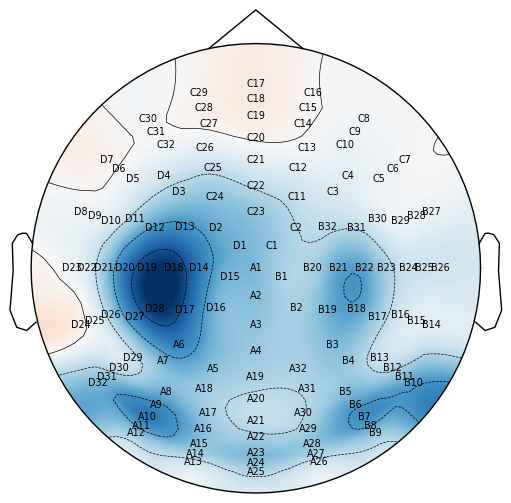

In [11]:
topo = mne.time_frequency.AverageTFR(info = info, data = topo_data, times = [0], freqs = np.array([int((fs_beta[0] + fs_beta[1]) / 2)]), nave = len(ID_list))
plt = topo.plot_topomap(tmin = -0.14, tmax = 0.01, show_names = True, size = 5, colorbar = False, sensors = False)
fname = "/content/drive/MyDrive/Time_Reproduction/" + "Plots" + "/" + "beta_topo.png"
plt.savefig(fname, dpi = 300, bbox_inches = "tight")

# Define What Electrodes we are using

In [12]:
right_electrodes = ["B18", "B19", "B21", "B22"]
left_electrodes = ["D28", "D18", "D19", "D17"]

right_idx = []
left_idx = []

for i in range(0, len(info.ch_names)):
  if info.ch_names[i] in right_electrodes:
    right_idx.append(i)
  elif info.ch_names[i] in left_electrodes:
    left_idx.append(i)

## Define what electrodes we are using for each participant (some used left hand) ##
ch_idx = list(np.zeros(len(ID_list)))
left_handers = ["P3", "P7"]

for i in range(0, len(ch_idx)):
  if ID_list[i] in left_handers:
    ch_idx[i] = right_idx
  else:
    ch_idx[i] = left_idx

# Paper Topoplots
Want to flip the hemispheres for people who were left handed so that we get all contralateral on one side

In [13]:
ch_stay_same = ['C17', 'C18','C19','C20','C21','C22', 'C23', 'A1', 'A2', 'A3', 'A4', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25'] # centre electrodes

left_hem = ["C29", "C28", "C27", "C26", "C25", "C24", "D2", "D1", "D15", "D16", "A5", "A18", "A17", "A16", "A15", "A14", "A13",
            "C30", "C31", "C32", "D4", "D3", "D13", "D14", "D17", "A6", "A7", "A8", "A9", "A10", "A11", "A12",
            "D7", "D6", "D5", "D8", "D9", "D10", "D11", "D12", "D23", "D22", "D21", "D20", "D19", "D18", "D24", "D25", "D26", "D27", "D28", "D32", "D31", "D30", "D29"]
right_hem = ["C16", "C15", "C14", "C13", "C12", "C11", "C2", "C1", "B1", "B2", "A32", "A31", "A30", "A29", "A28", "A27", "A26",
             "C8", "C9", "C10", "C4", "C3", "B32", "B20", "B19", "B3", "B4", "B5", "B6", "B7", "B8", "B9",
             "C7", "C6", "C5", "B27", "B28", "B29", "B30", "B31", "B26", "B25", "B24", "B23", "B22", "B21", "B14", "B15", "B16", "B17", "B18", "B10", "B11", "B12", "B13"]

print(len(ch_stay_same) + len(left_hem) + len(right_hem))

128


In [14]:
topo_data_all = np.zeros((len(ID_list), 128, 1, 1))

for i in range(0, len(ID_list)):
  if ID_list[i] in left_handers:
    beta_evidence_onset = np.mean(all_repo_beta[i, :, :, repo_window_start_idx:repo_window_end_idx], axis = 2)
    beta_response_onset = np.mean(all_RL_beta[i, :, :, RL_window_start_idx:RL_window_end_idx], axis = 2)
    topo_data = beta_response_onset - beta_evidence_onset
    topo_data =  topo_data[:, np.newaxis]
    print(topo_data.shape)
    print(ID_list[i])
    topo_data_flipped = np.zeros(topo_data.shape) # create empty array for containing the flipped hemispheres
    for j in range(0, topo_data.shape[0]):
      if topo.ch_names[j] in ch_stay_same:
        topo_data_flipped[j] = topo_data[j]
      elif topo.ch_names[j] in left_hem:
        opposite_electrode = right_hem[left_hem.index(topo.ch_names[j])] # get equivalent electrode in right hem for given index position in left hem
        topo_data_flipped[j] = topo_data[topo.ch_names.index(opposite_electrode)]
    topo_data_all[i] = topo_data_flipped
  else:
    beta_evidence_onset = np.mean(all_repo_beta[i, :, :, repo_window_start_idx:repo_window_end_idx], axis = 2)
    beta_response_onset = np.mean(all_RL_beta[i, :, :, RL_window_start_idx:RL_window_end_idx], axis = 2)
    topo_data = beta_response_onset - beta_evidence_onset
    topo_data =  topo_data[:, np.newaxis]
    topo_data_all[i] = topo_data


topo_data_all = np.mean(topo_data_all, axis = 0)

(128, 1, 1)
P3
(128, 1, 1)
P7


In [15]:
beta_mask = np.zeros(topo_data_all.shape)

for ch in left_idx:
  beta_mask[ch] = 1

mask_params = dict(marker='o', markerfacecolor='w', markeredgecolor='w',
        linewidth=0, markersize=4)

print(beta_mask.shape)

(128, 1, 1)


No baseline correction applied


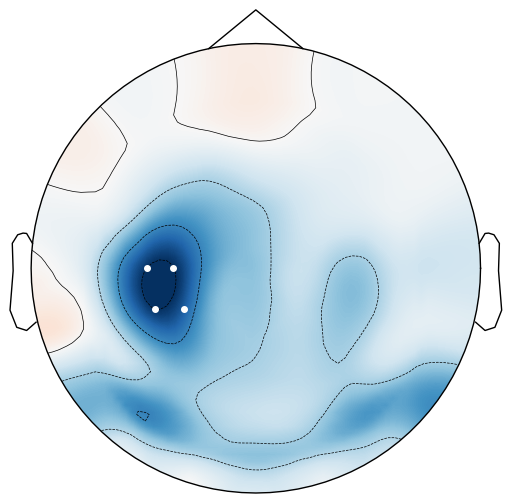

In [16]:
topo = mne.time_frequency.AverageTFR(info = info, data = topo_data_all, times = [0], freqs = np.array([int((fs_beta[0] + fs_beta[1]) / 2)]), nave = len(ID_list))
plt = topo.plot_topomap(tmin = -0.14, tmax = 0.01, show_names = False, size = 5, colorbar = False, sensors = False, mask = beta_mask, mask_params = mask_params)
fname = "/content/drive/MyDrive/Time_Reproduction/" + "Plots" + "/" + "beta_topo_flipped.png"
plt.savefig(fname, dpi = 300, bbox_inches = "tight")

# Define Time Windows for Calculations
For encoding: -100ms to +100ms from encoding offset to check offset amplitude? - How do you do this for sample interval bins? Take the average offset time?

For repo: check slope? Or baseline out the difference and then check the amplitude? Check amplitude at time of cue onset (-100 + 100ms)

For RL: -600ms to -300ms for measuring the slope?

In [17]:
# For checking amplitude at target offset
encode_amplitude_window_start = -100 / 1000
encode_amplitude_window_end = +100 / 1000# these have to be done within sample interval bin

# For checking the amplitude at cue onset
repo_amplitude_window_start = -120
repo_amplitude_window_start_idx = int(np.argwhere(beta_time_repo >= repo_amplitude_window_start / 1000)[0])
repo_amplitude_window_end = -65
repo_amplitude_window_end_idx = int(np.argwhere(beta_time_repo >= repo_amplitude_window_end / 1000)[0])

# For checking build-up rate in anticipation of response
RL_slope_window_start = -600
RL_slope_window_start_idx = int(np.argwhere(beta_time_RL >= RL_slope_window_start / 1000)[0])
RL_slope_window_end = -300
RL_slope_window_end_idx = int(np.argwhere(beta_time_RL >= RL_slope_window_end / 1000)[0])

# Plot Lineplots Separated by Sample Interval

## Load Data

In [18]:
encode_SIs = np.unique(encode_metadata["Trigger"]) # SI trigger codes
repo_SIs = np.unique(repo_metadata["Trigger"]) # SI trigger codes
RL_SIs = np.unique(RL_metadata["Trigger"])

n_conditions = len(encode_SIs)
encode_conditions = np.zeros([len(ID_list), n_conditions, len(ch_idx[0]), 1, n_times_encode])
repo_conditions = np.zeros([len(ID_list), n_conditions, len(ch_idx[0]), 1, n_times_repo])
RL_conditions = np.zeros([len(ID_list), n_conditions, len(ch_idx[0]), 1, n_times_RL])
median_RT_conditions_unbinned = np.zeros([len(ID_list), n_conditions])

for i in range(0, len(ID_list)):
  ID = ID_list[i]
  encode_fname = "/content/drive/MyDrive/Time_Reproduction/Beta_Epochs/" + ID + "_encode_beta_epochs-tfr.h5"
  repo_fname = "/content/drive/MyDrive/Time_Reproduction/Beta_Epochs/" + ID + "_repo_beta_epochs-tfr.h5"
  RL_fname = "/content/drive/MyDrive/Time_Reproduction/Beta_Epochs/" + ID + "_RL_beta_epochs-tfr.h5"

  encode_epochs_participant = mne.time_frequency.read_tfrs(encode_fname)
  encode_epochs_participant = encode_epochs_participant[0]
  repo_epochs_participant = mne.time_frequency.read_tfrs(repo_fname)
  repo_epochs_participant = repo_epochs_participant[0]
  RL_epochs_participant = mne.time_frequency.read_tfrs(RL_fname)
  RL_epochs_participant = RL_epochs_participant[0]

  info = encode_epochs_participant.info

  for j in range(0, n_conditions):
    encode_SI = encode_SIs[j]
    repo_SI = repo_SIs[j]
    RL_SI = RL_SIs[j]

    #encode_indices = encode_epochs_participant.metadata.query("Trigger == @encode_SI & Response_Time > @lower_RT_cutoff & Response_Time < @upper_RT_cutoff").index # get trials for that condition
    #repo_indices = repo_epochs_participant.metadata.query("Trigger == @repo_SI & Response_Time > @lower_RT_cutoff & Response_Time < @upper_RT_cutoff").index
    #RL_indices = RL_epochs_participant.metadata.query("Trigger == @RL_SI & Response_Time > @lower_RT_cutoff & Response_Time < @upper_RT_cutoff").index

    encode_indices = encode_epochs_participant.metadata[(encode_epochs_participant.metadata["Trigger"] == encode_SI) & (encode_epochs_participant.metadata["Response_Time"] > lower_RT_cutoff) & (encode_epochs_participant.metadata["Response_Time"] < upper_RT_cutoff)].index
    repo_indices = repo_epochs_participant.metadata[(repo_epochs_participant.metadata["Trigger"] == repo_SI) & (repo_epochs_participant.metadata["Response_Time"] > lower_RT_cutoff) & (repo_epochs_participant.metadata["Response_Time"] < upper_RT_cutoff)].index
    RL_indices = RL_epochs_participant.metadata[(RL_epochs_participant.metadata["Trigger"] == RL_SI) & (RL_epochs_participant.metadata["Response_Time"] > lower_RT_cutoff) & (RL_epochs_participant.metadata["Response_Time"] < upper_RT_cutoff)].index

    encode_epochs_trials = encode_epochs_participant[encode_indices]
    repo_epochs_trials = repo_epochs_participant[repo_indices]
    RL_epochs_trials = RL_epochs_participant[RL_indices]

    encode_electrodes = encode_epochs_trials.copy().pick(ch_idx[i])
    encode_participant_beta = encode_electrodes.average()
    encode_conditions[i, j] = encode_participant_beta.data

    repo_electrodes = repo_epochs_trials.copy().pick(ch_idx[i])
    repo_participant_beta = repo_electrodes.average()
    repo_conditions[i, j] = repo_participant_beta.data

    median_RT_conditions_unbinned[i, j] = repo_epochs_participant[repo_indices].metadata["Response_Time"].median()

    RL_electrodes = RL_epochs_trials.copy().pick(ch_idx[i])
    RL_participant_beta = RL_electrodes.average()
    RL_conditions[i, j] = RL_participant_beta.data

Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P1_encode_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P1_repo_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P1_RL_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P3_encode_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P3_repo_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P3_RL_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P4_encode_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P4_repo_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Readin

In [19]:
print(encode_conditions.shape)

(18, 9, 4, 1, 41)


## Copying Data for Plotting by Sample Interval Bins
So we don't have to load data again

In [20]:
encode_conditions_unbinned = encode_conditions.copy()
repo_conditions_unbinned = repo_conditions.copy()
RL_conditions_unbinned = RL_conditions.copy()

## Average Across Channels

In [21]:
encode_conditions = np.mean(encode_conditions, axis = 2)
repo_conditions = np.mean(repo_conditions, axis = 2)
RL_conditions = np.mean(RL_conditions, axis = 2)

In [22]:
print(encode_conditions.shape)

(18, 9, 1, 41)


## Average Across Participants

In [23]:
encode_conditions = np.mean(encode_conditions, axis = 0)
repo_conditions = np.mean(repo_conditions, axis = 0)
RL_conditions = np.mean(RL_conditions, axis = 0)

print(encode_conditions.shape)

(9, 1, 41)


## Plot

In [24]:
from matplotlib import pyplot as plt
%matplotlib inline
labels = np.arange(600, 1001, 50)

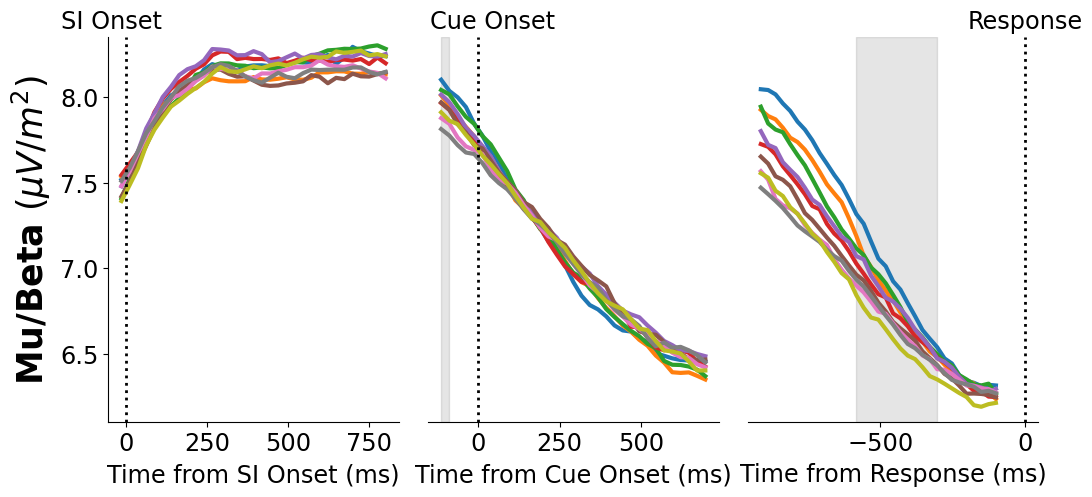

In [25]:
fig = plt.figure(figsize = (12,5))

grid = plt.GridSpec(1, 3, wspace = 0.1)

ax1 = fig.add_subplot(grid[0])
ax2 = fig.add_subplot(grid[1])
ax3 = fig.add_subplot(grid[2])

## Encode Plot
for j in range(0, n_conditions):
  sns.lineplot(x = beta_time[beta_time <= (800/1000)] * 1000, y = encode_conditions[j, 0, beta_time <= (800/1000)], label = labels[j], linewidth = 3, ax = ax1, legend = False)

## Remove box around first plot
sns.despine(ax = ax1)

## Plot legend
#ax1.legend(fontsize = "xx-large", loc = "lower left", title = "Sample Interval Bin", title_fontsize = "xx-large")

## Set Axes Labels and format of them
ax1.set_xlabel("Time from SI Onset (ms)", fontsize = "xx-large", labelpad = 5) # labelpad determines how far from axis the label is
ax1.set_ylabel("Mu/Beta" + " " + "$(\mu V/m^2)$", fontsize = 25, labelpad = 5, weight='bold')

## Set ylim - need to do this
ax1.set_ylim(6.1, 8.35)

## For modifying the ticks and the tick labels
ax1.tick_params(labelsize = "xx-large")

## Plotting vertical line at time of target onset
ax1.vlines(0, ax1.get_ylim()[0], ax1.get_ylim()[1], color = "k", linestyle = "dotted", linewidth = 2)

## Plotting text above target onset line
ax1.text(x = -200, y = 8.4, s = "SI Onset", fontsize = "xx-large") # adjust x to move left or right

## Repo Plot ##
for j in range(0, n_conditions):
  sns.lineplot(x = beta_time_repo * 1000, y = repo_conditions[j, 0], label = labels[j], linewidth = 3, ax = ax2, legend = False)

## Remove box around second plot
sns.despine(ax = ax2)
## Set Axes Labels and format of them - decided not to plot y axis label on second plot
ax2.set_xlabel("Time from Cue Onset (ms)", fontsize = "xx-large", labelpad = 5)

## Set ylim - need to do this manually for maximum customisation
ax2.set_ylim(6.1, 8.35)

## Add shaded portion ##
b = 6.1
t = 8.35
bottom = b * (np.ones(len(beta_time_repo[repo_amplitude_window_start_idx : repo_amplitude_window_end_idx])))
top =  t * (np.ones(len(beta_time_repo[repo_amplitude_window_start_idx : repo_amplitude_window_end_idx])))
ax2.fill_between(x = beta_time_repo[repo_amplitude_window_start_idx : repo_amplitude_window_end_idx] * 1000, y1 = bottom, y2 = top, color = "black", alpha = 0.1)

## Plotting vertical line at time of cue onset
ax2.vlines(0, ax2.get_ylim()[0], ax2.get_ylim()[1], color = "k", linestyle = "dotted", linewidth = 2)

## For modifying the ticks and the tick labels
ax2.tick_params(labelsize = "xx-large")

## Add Mean Response Time Vertical Lines?

## Removing left spine from second plot
ax2.spines["left"].set_visible(False)
ax2.set_yticks([])

## Plotting text above cue onset line
ax2.text(x = -150, y = 8.4, s = "Cue Onset", fontsize = "xx-large") # adjust x to move left or right
## RL Plot ##
for j in range(0, n_conditions):
  sns.lineplot(x = beta_time_RL * 1000, y = RL_conditions[j, 0], label = labels[j], linewidth = 3, ax = ax3, legend = False)

## Remove box around second plot
sns.despine(ax = ax3)
## Set Axes Labels and format of them - decided not to plot y axis label on second plot
ax3.set_xlabel("Time from Response (ms)", fontsize = "xx-large", labelpad = 5)

## Set ylim - need to do this manually for maximum customisation
ax3.set_ylim(6.1, 8.35)

## Add shaded portion ##
b = 6.1
t = 8.35
bottom = b * (np.ones(len(beta_time_RL[RL_slope_window_start_idx : RL_slope_window_end_idx])))
top =  t * (np.ones(len(beta_time_RL[RL_slope_window_start_idx : RL_slope_window_end_idx])))
ax3.fill_between(x = beta_time_RL[RL_slope_window_start_idx : RL_slope_window_end_idx] * 1000, y1 = bottom, y2 = top, color = "black", alpha = 0.1)

## For modifying the ticks and the tick labels
ax3.tick_params(labelsize = "xx-large")

## Plotting vertical dotted line response
ax3.vlines(0, ax2.get_ylim()[0], ax3.get_ylim()[1], color = "k", linestyle = "dotted", linewidth = 2)

## Plotting text above response line
ax3.text(x = -200, y = 8.4, s = "Response", fontsize = "xx-large") # adjust x to move left or right

## Removing left spine from second plot
ax3.spines["left"].set_visible(False)
ax3.set_yticks([])

fname = "/content/drive/MyDrive/Time_Reproduction/Plots/Beta" + "Beta_SI.png"
plt.savefig(fname, dpi = 300, bbox_inches = "tight")

# Plot Lineplots Separated by Sample Interval Bin

## Average Across Sample Intervals

In [26]:
print(encode_conditions_unbinned.shape)

(18, 9, 4, 1, 41)


In [27]:
n_conditions = 3

encode_conditions = np.zeros([len(ID_list), n_conditions, len(ch_idx[0]), 1, n_times_encode])
repo_conditions = np.zeros([len(ID_list), n_conditions, len(ch_idx[0]), 1, n_times_repo])
RL_conditions = np.zeros([len(ID_list), n_conditions, len(ch_idx[0]), 1, n_times_RL])
median_RT_conditions = np.zeros([len(ID_list), n_conditions])

for i in range(0, len(ID_list)):
  encode_conditions[i, 0] = np.nanmean(encode_conditions_unbinned[i, 0:3], axis = 0)
  encode_conditions[i, 1] = np.nanmean(encode_conditions_unbinned[i, 3:6], axis = 0)
  encode_conditions[i, 2] = np.nanmean(encode_conditions_unbinned[i, 6:9], axis = 0)

  repo_conditions[i, 0] = np.nanmean(repo_conditions_unbinned[i, 0:3], axis = 0)
  repo_conditions[i, 1] = np.nanmean(repo_conditions_unbinned[i, 3:6], axis = 0)
  repo_conditions[i, 2] = np.nanmean(repo_conditions_unbinned[i, 6:9], axis = 0)

  RL_conditions[i, 0] = np.nanmean(RL_conditions_unbinned[i, 0:3], axis = 0)
  RL_conditions[i, 1] = np.nanmean(RL_conditions_unbinned[i, 3:6], axis = 0)
  RL_conditions[i, 2] = np.nanmean(RL_conditions_unbinned[i, 6:9], axis = 0)

  median_RT_conditions[i, 0] = np.nanmean(median_RT_conditions_unbinned[i, 0:3], axis = 0)
  median_RT_conditions[i, 1] = np.nanmean(median_RT_conditions_unbinned[i, 3:6], axis = 0)
  median_RT_conditions[i, 2] = np.nanmean(median_RT_conditions_unbinned[i, 6:9], axis = 0)

## Average Across Channels

In [28]:
encode_conditions = np.mean(encode_conditions, axis = 2)
repo_conditions = np.mean(repo_conditions, axis = 2)
RL_conditions = np.mean(RL_conditions, axis = 2)

In [29]:
print(encode_conditions.shape)

(18, 3, 1, 41)


## Average Across Participants

In [30]:
encode_conditions = np.mean(encode_conditions, axis = 0)
repo_conditions = np.mean(repo_conditions, axis = 0)
RL_conditions = np.mean(RL_conditions, axis = 0)
median_RT_conditions = np.nanmean(median_RT_conditions, axis = 0)

print(encode_conditions.shape)

(3, 1, 41)


## Plot

In [31]:
from matplotlib import pyplot as plt
%matplotlib inline
alphas = [1, 0.66, 0.33]
labels = ["Short", "Medium", "Long"]

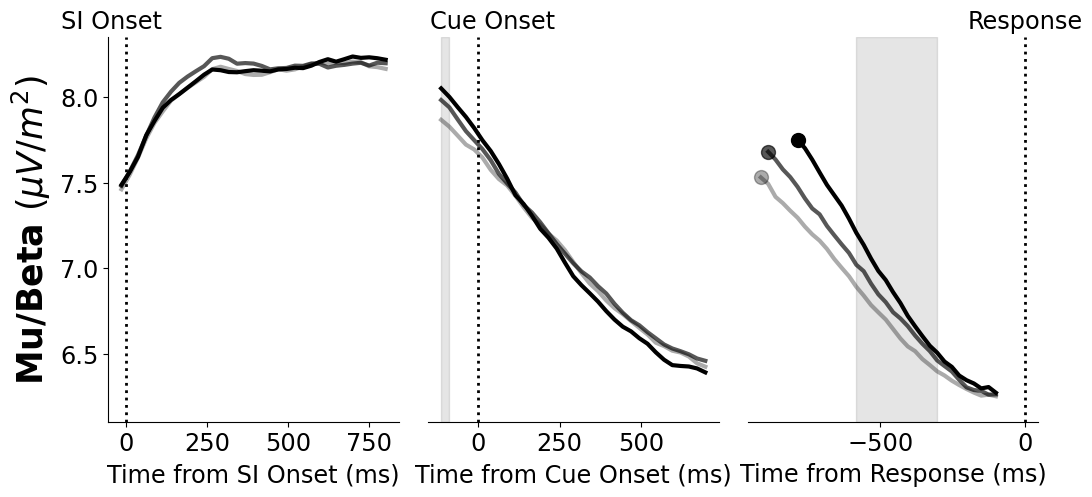

In [32]:
fig = plt.figure(figsize = (12,5))

grid = plt.GridSpec(1, 3, wspace = 0.1)

ax1 = fig.add_subplot(grid[0])
ax2 = fig.add_subplot(grid[1])
ax3 = fig.add_subplot(grid[2])

## Encode Plot
for j in range(0, n_conditions):
  sns.lineplot(x = beta_time[beta_time <= (800/1000)] * 1000, y = encode_conditions[j, 0, beta_time <= (800/1000)], color = "k", alpha = alphas[j], label = labels[j], linewidth = 3, ax = ax1, legend = False)

## Remove box around first plot
sns.despine(ax = ax1)

## Plot legend
#ax1.legend(fontsize = "xx-large", loc = "lower left", title = "Sample Interval Bin", title_fontsize = "xx-large")

## Set Axes Labels and format of them
ax1.set_xlabel("Time from SI Onset (ms)", fontsize = "xx-large", labelpad = 5) # labelpad determines how far from axis the label is
ax1.set_ylabel("Mu/Beta" + " " + "$(\mu V/m^2)$", fontsize = 25, labelpad = 5, weight='bold')

## Set ylim - need to do this
ax1.set_ylim(6.1, 8.35)

## For modifying the ticks and the tick labels
ax1.tick_params(labelsize = "xx-large")

## Plotting vertical line at time of target onset
ax1.vlines(0, ax1.get_ylim()[0], ax1.get_ylim()[1], color = "k", linestyle = "dotted", linewidth = 2)

## Plotting text above target onset line
ax1.text(x = -200, y = 8.4, s = "SI Onset", fontsize = "xx-large") # adjust x to move left or right

## Repo Plot ##
for j in range(0, n_conditions):
  sns.lineplot(x = beta_time_repo * 1000, y = repo_conditions[j, 0], label = labels[j], color = "k", alpha = alphas[j], linewidth = 3, ax = ax2, legend = False)

## Remove box around second plot
sns.despine(ax = ax2)
## Set Axes Labels and format of them - decided not to plot y axis label on second plot
ax2.set_xlabel("Time from Cue Onset (ms)", fontsize = "xx-large", labelpad = 5)

## Set ylim - need to do this manually for maximum customisation
ax2.set_ylim(6.1, 8.35)

## Add shaded portion ##
b = 6.1
t = 8.35
bottom = b * (np.ones(len(beta_time_repo[repo_amplitude_window_start_idx : repo_amplitude_window_end_idx])))
top =  t * (np.ones(len(beta_time_repo[repo_amplitude_window_start_idx : repo_amplitude_window_end_idx])))
ax2.fill_between(x = beta_time_repo[repo_amplitude_window_start_idx : repo_amplitude_window_end_idx] * 1000, y1 = bottom, y2 = top, color = "black", alpha = 0.1)

## Plotting vertical line at time of cue onset
ax2.vlines(0, ax2.get_ylim()[0], ax2.get_ylim()[1], color = "k", linestyle = "dotted", linewidth = 2)

## For modifying the ticks and the tick labels
ax2.tick_params(labelsize = "xx-large")

## Add Mean Response Time Vertical Lines?

## Removing left spine from second plot
ax2.spines["left"].set_visible(False)
ax2.set_yticks([])

## Plotting text above cue onset line
ax2.text(x = -150, y = 8.4, s = "Cue Onset", fontsize = "xx-large") # adjust x to move left or right
## RL Plot ##
for j in range(0, n_conditions):
  sns.lineplot(x = beta_time_RL[(beta_time_RL * 1000) > (-median_RT_conditions[j])] * 1000, y = RL_conditions[j, 0, (beta_time_RL * 1000) > (-median_RT_conditions[j])], label = labels[j], color = "k", alpha = alphas[j], linewidth = 3, ax = ax3, legend = False)
  ax3.plot(beta_time_RL[np.where((beta_time_RL * 1000) > (-median_RT_conditions[j]))[0][0]] * 1000, RL_conditions[j, 0, np.where((beta_time_RL * 1000) > (-median_RT_conditions[j]))[0][0]], marker = "o", markersize = 10, markeredgecolor = "k", color = "k", alpha = alphas[j])

## Remove box around second plot
sns.despine(ax = ax3)
## Set Axes Labels and format of them - decided not to plot y axis label on second plot
ax3.set_xlabel("Time from Response (ms)", fontsize = "xx-large", labelpad = 5)

## Set ylim - need to do this manually for maximum customisation
ax3.set_ylim(6.1, 8.35)

## Add shaded portion ##
b = 6.1
t = 8.35
bottom = b * (np.ones(len(beta_time_RL[RL_slope_window_start_idx : RL_slope_window_end_idx])))
top =  t * (np.ones(len(beta_time_RL[RL_slope_window_start_idx : RL_slope_window_end_idx])))
ax3.fill_between(x = beta_time_RL[RL_slope_window_start_idx : RL_slope_window_end_idx] * 1000, y1 = bottom, y2 = top, color = "black", alpha = 0.1)

## For modifying the ticks and the tick labels
ax3.tick_params(labelsize = "xx-large")

## Plotting vertical dotted line response
ax3.vlines(0, ax2.get_ylim()[0], ax3.get_ylim()[1], color = "k", linestyle = "dotted", linewidth = 2)

## Plotting text above response line
ax3.text(x = -200, y = 8.4, s = "Response", fontsize = "xx-large") # adjust x to move left or right

## Removing left spine from second plot
ax3.spines["left"].set_visible(False)
ax3.set_yticks([])

fname = "/content/drive/MyDrive/Time_Reproduction/Plots/Beta" + "Beta_Sample_Interval_Bins.png"
plt.savefig(fname, dpi = 300, bbox_inches = "tight")

# Plot Lineplots Separated by RT Bin

In [33]:
n_bins = 2
n_conditions = len(encode_SIs)
encode_conditions_SI = np.zeros([len(ID_list), n_conditions, n_bins, len(ch_idx[0]), 1, n_times_encode])
repo_conditions_SI = np.zeros([len(ID_list), n_conditions, n_bins, len(ch_idx[0]), 1, n_times_repo])
RL_conditions_SI = np.zeros([len(ID_list), n_conditions, n_bins, len(ch_idx[0]), 1, n_times_RL])

median_RT = np.zeros([len(ID_list), n_conditions, n_bins])

for i in range(0, len(ID_list)):
  ID = ID_list[i]
  encode_fname = "/content/drive/MyDrive/Time_Reproduction/Beta_Epochs/" + ID + "_encode_beta_epochs-tfr.h5"
  repo_fname = "/content/drive/MyDrive/Time_Reproduction/Beta_Epochs/" + ID + "_repo_beta_epochs-tfr.h5"
  RL_fname = "/content/drive/MyDrive/Time_Reproduction/Beta_Epochs/" + ID + "_RL_beta_epochs-tfr.h5"

  encode_epochs_participant = mne.time_frequency.read_tfrs(encode_fname)
  encode_epochs_participant = encode_epochs_participant[0]
  repo_epochs_participant = mne.time_frequency.read_tfrs(repo_fname)
  repo_epochs_participant = repo_epochs_participant[0]
  RL_epochs_participant = mne.time_frequency.read_tfrs(RL_fname)
  RL_epochs_participant = RL_epochs_participant[0]

  info = encode_epochs_participant.info

  for j in range(0, n_conditions):
    encode_SI = encode_SIs[j]
    repo_SI = repo_SIs[j]
    RL_SI = RL_SIs[j]
    ## Getting Median For Each Type of Epoch
    #encode_indices_metadata = encode_epochs_participant.metadata.query("Trigger == @encode_SI & Response_Time > @lower_RT_cutoff & Response_Time < @upper_RT_cutoff")
    encode_indices_metadata = encode_epochs_participant.metadata[(encode_epochs_participant.metadata["Trigger"] == encode_SI) & (encode_epochs_participant.metadata["Response_Time"] > lower_RT_cutoff) & (encode_epochs_participant.metadata["Response_Time"] < upper_RT_cutoff)]
    encode_median = encode_indices_metadata["Response_Time"].median()
    #repo_indices_metadata = repo_epochs_participant.metadata.query("Trigger == @repo_SI & Response_Time > @lower_RT_cutoff & Response_Time < @upper_RT_cutoff")
    repo_indices_metadata = repo_epochs_participant.metadata[(repo_epochs_participant.metadata["Trigger"] == repo_SI) & (repo_epochs_participant.metadata["Response_Time"] > lower_RT_cutoff) & (repo_epochs_participant.metadata["Response_Time"] < upper_RT_cutoff)]
    repo_median = repo_indices_metadata["Response_Time"].median()
    #RL_indices_metadata = RL_epochs_participant.metadata.query("Trigger == @RL_SI & Response_Time > @lower_RT_cutoff & Response_Time < @upper_RT_cutoff")
    RL_indices_metadata = RL_epochs_participant.metadata[(RL_epochs_participant.metadata["Trigger"] == RL_SI) & (RL_epochs_participant.metadata["Response_Time"] > lower_RT_cutoff) & (RL_epochs_participant.metadata["Response_Time"] < upper_RT_cutoff)]
    RL_median = RL_indices_metadata["Response_Time"].median()

    ## Getting Trials Above and Below the Median
    # Above
    #encode_above_indices = encode_epochs_participant.metadata.query("Trigger == @encode_SI & Response_Time > @encode_median & Response_Time > @lower_RT_cutoff & Response_Time < @upper_RT_cutoff").index # get trials for that condition
    #repo_above_indices = repo_epochs_participant.metadata.query("Trigger == @repo_SI & Response_Time > @repo_median & Response_Time > @lower_RT_cutoff & Response_Time < @upper_RT_cutoff").index
    #RL_above_indices = RL_epochs_participant.metadata.query("Trigger == @RL_SI & Response_Time > @RL_median & Response_Time > @lower_RT_cutoff & Response_Time < @upper_RT_cutoff").index

    encode_above_indices = encode_epochs_participant.metadata[(encode_epochs_participant.metadata["Trigger"] == encode_SI) & (encode_epochs_participant.metadata["Response_Time"] > lower_RT_cutoff) & (encode_epochs_participant.metadata["Response_Time"] < upper_RT_cutoff) & (encode_epochs_participant.metadata["Response_Time"] > encode_median)].index
    repo_above_indices = repo_epochs_participant.metadata[(repo_epochs_participant.metadata["Trigger"] == repo_SI) & (repo_epochs_participant.metadata["Response_Time"] > lower_RT_cutoff) & (repo_epochs_participant.metadata["Response_Time"] < upper_RT_cutoff) & (repo_epochs_participant.metadata["Response_Time"] > repo_median)].index
    RL_above_indices = RL_epochs_participant.metadata[(RL_epochs_participant.metadata["Trigger"] == RL_SI) & (RL_epochs_participant.metadata["Response_Time"] > lower_RT_cutoff) & (RL_epochs_participant.metadata["Response_Time"] < upper_RT_cutoff) & (RL_epochs_participant.metadata["Response_Time"] > RL_median)].index

    #mean_RT_metadata = RL_epochs_participant.metadata.query("Trigger == @RL_SI & Response_Time > @RL_median & Response_Time > @lower_RT_cutoff & Response_Time < @upper_RT_cutoff")
    median_RT_metadata = RL_epochs_participant.metadata[(RL_epochs_participant.metadata["Trigger"] == RL_SI) & (RL_epochs_participant.metadata["Response_Time"] > lower_RT_cutoff) & (RL_epochs_participant.metadata["Response_Time"] < upper_RT_cutoff) & (RL_epochs_participant.metadata["Response_Time"] > RL_median)]
    median_RT[i, j, 0] = median_RT_metadata["Response_Time"].median()
    encode_epochs_above = encode_epochs_participant[encode_above_indices]
    encode_electrodes_above = encode_epochs_above.copy().pick(ch_idx[i])
    encode_above = encode_electrodes_above.average()
    encode_conditions_SI[i, j, 0] = encode_above.data
    RL_epochs_above = RL_epochs_participant[RL_above_indices]
    RL_electrodes_above = RL_epochs_above.copy().pick(ch_idx[i])
    RL_above = RL_electrodes_above.average()
    RL_conditions_SI[i, j, 0] = RL_above.data
    repo_epochs_above = repo_epochs_participant[repo_above_indices]
    repo_electrodes_above = repo_epochs_above.copy().pick(ch_idx[i])
    repo_above = repo_electrodes_above.average()
    repo_conditions_SI[i, j, 0] = repo_above.data

    # Below
    #encode_below_indices = encode_epochs_participant.metadata.query("Trigger == @encode_SI & Response_Time < @encode_median & Response_Time > @lower_RT_cutoff & Response_Time < @upper_RT_cutoff").index # get trials for that condition
    #repo_below_indices = repo_epochs_participant.metadata.query("Trigger == @repo_SI & Response_Time < @repo_median & Response_Time > @lower_RT_cutoff & Response_Time < @upper_RT_cutoff").index
    #RL_below_indices = RL_epochs_participant.metadata.query("Trigger == @RL_SI & Response_Time < @RL_median & Response_Time > @lower_RT_cutoff & Response_Time < @upper_RT_cutoff").index

    encode_below_indices = encode_epochs_participant.metadata[(encode_epochs_participant.metadata["Trigger"] == encode_SI) & (encode_epochs_participant.metadata["Response_Time"] > lower_RT_cutoff) & (encode_epochs_participant.metadata["Response_Time"] < upper_RT_cutoff) & (encode_epochs_participant.metadata["Response_Time"] < encode_median)].index
    repo_below_indices = repo_epochs_participant.metadata[(repo_epochs_participant.metadata["Trigger"] == repo_SI) & (repo_epochs_participant.metadata["Response_Time"] > lower_RT_cutoff) & (repo_epochs_participant.metadata["Response_Time"] < upper_RT_cutoff) & (repo_epochs_participant.metadata["Response_Time"] < repo_median)].index
    RL_below_indices = RL_epochs_participant.metadata[(RL_epochs_participant.metadata["Trigger"] == RL_SI) & (RL_epochs_participant.metadata["Response_Time"] > lower_RT_cutoff) & (RL_epochs_participant.metadata["Response_Time"] < upper_RT_cutoff) & (RL_epochs_participant.metadata["Response_Time"] < RL_median)].index

    #mean_RT_metadata = RL_epochs_participant.metadata.query("Trigger == @RL_SI & Response_Time < @RL_median & Response_Time > @lower_RT_cutoff & Response_Time < @upper_RT_cutoff")
    median_RT_metadata = RL_epochs_participant.metadata[(RL_epochs_participant.metadata["Trigger"] == RL_SI) & (RL_epochs_participant.metadata["Response_Time"] > lower_RT_cutoff) & (RL_epochs_participant.metadata["Response_Time"] < upper_RT_cutoff) & (RL_epochs_participant.metadata["Response_Time"] < RL_median)]
    median_RT[i, j, 1] = median_RT_metadata["Response_Time"].median()
    encode_epochs_below = encode_epochs_participant[encode_below_indices]
    encode_electrodes_below = encode_epochs_below.copy().pick(ch_idx[i])
    encode_below = encode_electrodes_below.average()
    encode_conditions_SI[i, j, 1] = encode_below.data
    RL_epochs_below = RL_epochs_participant[RL_below_indices]
    RL_electrodes_below = RL_epochs_below.copy().pick(ch_idx[i])
    RL_below = RL_electrodes_below.average()
    RL_conditions_SI[i, j, 1] = RL_below.data
    repo_epochs_below = repo_epochs_participant[repo_below_indices]
    repo_electrodes_below = repo_epochs_below.copy().pick(ch_idx[i])
    repo_below = repo_electrodes_below.average()
    repo_conditions_SI[i, j, 1] = repo_below.data

Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P1_encode_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P1_repo_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P1_RL_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P3_encode_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P3_repo_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P3_RL_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P4_encode_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P4_repo_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Readin

## Average Across Sample Intervals
Averaging bins across sample intervals now to get RT bins that are separate from sample interval

In [34]:
encode_conditions = np.zeros([len(ID_list), n_bins, len(ch_idx[0]), 1, n_times_encode])
repo_conditions = np.zeros([len(ID_list), n_bins, len(ch_idx[0]), 1, n_times_repo])
RL_conditions = np.zeros([len(ID_list), n_bins, len(ch_idx[0]), 1, n_times_RL])
median_RT_conditions = np.zeros([len(ID_list), n_bins])

for i in range(0, len(ID_list)):

    for k in range(0, n_bins):
      encode_conditions[i, k] = np.nanmean(encode_conditions_SI[i, :, k], axis = 0)
      repo_conditions[i, k] = np.nanmean(repo_conditions_SI[i, :, k], axis = 0)
      RL_conditions[i, k] = np.nanmean(RL_conditions_SI[i, :, k], axis = 0)
      median_RT_conditions[i, k] = np.nanmean(median_RT[i, :, k], axis = 0)

print(median_RT_conditions.shape)
print(encode_conditions.shape)

(18, 2)
(18, 2, 4, 1, 41)


## Average Across Channels

In [35]:
encode_conditions = np.mean(encode_conditions, axis = 2)
repo_conditions = np.mean(repo_conditions, axis = 2)
RL_conditions = np.mean(RL_conditions, axis = 2)

print(encode_conditions.shape)

(18, 2, 1, 41)


## Average Across Participants

In [36]:
encode_conditions = np.mean(encode_conditions, axis = 0)
repo_conditions = np.mean(repo_conditions, axis = 0)
RL_conditions = np.mean(RL_conditions, axis = 0)

median_RT_conditions = np.mean(median_RT_conditions, axis = 0)

print(encode_conditions.shape)

(2, 1, 41)


## Plot

In [37]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use("seaborn-colorblind")
labels = ["Slower", "Faster"]
colors = ["blue", "red"]

print(median_RT_conditions)

[1003.3275463   794.13218557]


<ipython-input-37-b84da3040aa0>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-colorblind")


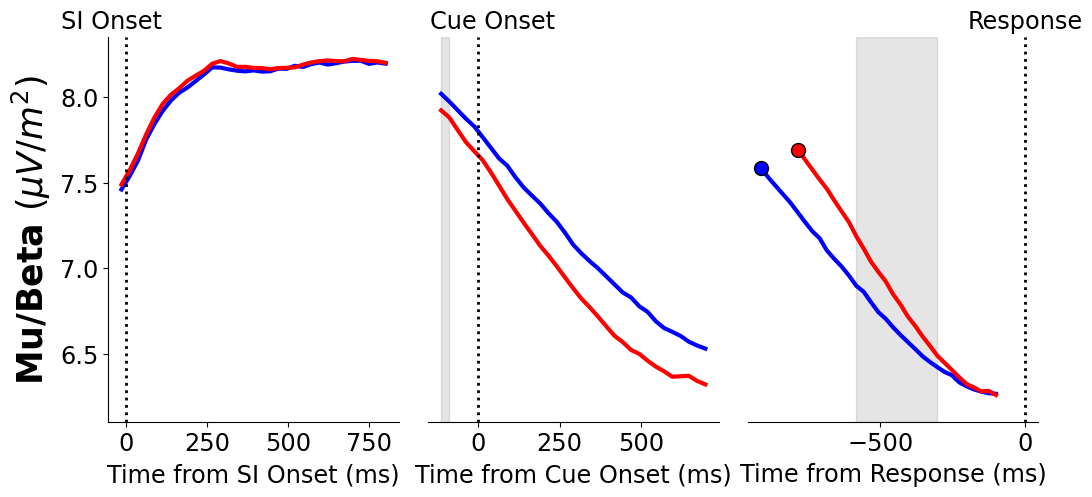

In [38]:
fig = plt.figure(figsize = (12,5))

grid = plt.GridSpec(1, 3, wspace = 0.1)

ax1 = fig.add_subplot(grid[0])
ax2 = fig.add_subplot(grid[1])
ax3 = fig.add_subplot(grid[2])

## Encode Plot
for j in range(0, n_bins):
  sns.lineplot(x = beta_time[beta_time <= (800/1000)] * 1000, y = encode_conditions[j, 0, beta_time <= (800/1000)], color = colors[j], label = labels[j], linewidth = 3, ax = ax1, legend = False)

## Remove box around first plot
sns.despine(ax = ax1)

## Plot legend
#ax1.legend(fontsize = "xx-large", loc = "lower left", title = "RT Bin", title_fontsize = "xx-large")

## Set Axes Labels and format of them
ax1.set_xlabel("Time from SI Onset (ms)", fontsize = "xx-large", labelpad = 5) # labelpad determines how far from axis the label is
ax1.set_ylabel("Mu/Beta" + " " + "$(\mu V/m^2)$", fontsize = 25, labelpad = 5, weight='bold')

## Set ylim - need to do this
ax1.set_ylim(6.1, 8.35)

## For modifying the ticks and the tick labels
ax1.tick_params(labelsize = "xx-large")

## Plotting vertical line at time of target onset
ax1.vlines(0, ax1.get_ylim()[0], ax1.get_ylim()[1], color = "k", linestyle = "dotted", linewidth = 2)

## Plotting text above target onset line
ax1.text(x = -200, y = 8.4, s = "SI Onset", fontsize = "xx-large") # adjust x to move left or right

## Repo Plot ##
for j in range(0, n_bins):
  sns.lineplot(x = beta_time_repo * 1000, y = repo_conditions[j, 0], label = labels[j], color = colors[j], linewidth = 3, ax = ax2, legend = False)

## Remove box around second plot
sns.despine(ax = ax2)
## Set Axes Labels and format of them - decided not to plot y axis label on second plot
ax2.set_xlabel("Time from Cue Onset (ms)", fontsize = "xx-large", labelpad = 5)

## Set ylim - need to do this manually for maximum customisation
ax2.set_ylim(6.1, 8.35)

## Add shaded portion ##
b = 6.1
t = 8.35
bottom = b * (np.ones(len(beta_time_repo[repo_amplitude_window_start_idx : repo_amplitude_window_end_idx])))
top =  t * (np.ones(len(beta_time_repo[repo_amplitude_window_start_idx : repo_amplitude_window_end_idx])))
ax2.fill_between(x = beta_time_repo[repo_amplitude_window_start_idx : repo_amplitude_window_end_idx] * 1000, y1 = bottom, y2 = top, color = "black", alpha = 0.1)

## Plotting vertical line at time of cue onset
ax2.vlines(0, ax2.get_ylim()[0], ax2.get_ylim()[1], color = "k", linestyle = "dotted", linewidth = 2)

## For modifying the ticks and the tick labels
ax2.tick_params(labelsize = "xx-large")

## Removing left spine from second plot
ax2.spines["left"].set_visible(False)
ax2.set_yticks([])

## Plotting text above cue onset line
ax2.text(x = -150, y = 8.4, s = "Cue Onset", fontsize = "xx-large") # adjust x to move left or right

## RL Plot ##
for j in range(0, n_bins):
  sns.lineplot(x = beta_time_RL[(beta_time_RL * 1000) > (-median_RT_conditions[j])] * 1000, y = RL_conditions[j, 0, (beta_time_RL * 1000) > (-median_RT_conditions[j])], label = labels[j], color = colors[j], linewidth = 3, ax = ax3, legend = False)
  ax3.plot(beta_time_RL[np.where((beta_time_RL * 1000) > (-median_RT_conditions[j]))[0][0]] * 1000, RL_conditions[j, 0, np.where((beta_time_RL * 1000) > (-median_RT_conditions[j]))[0][0]], marker = "o", markersize = 10, markeredgecolor = "k", color = colors[j])

## Remove box around second plot
sns.despine(ax = ax3)
## Set Axes Labels and format of them - decided not to plot y axis label on second plot
ax3.set_xlabel("Time from Response (ms)", fontsize = "xx-large", labelpad = 5)

## Set ylim - need to do this manually for maximum customisation
ax3.set_ylim(6.1, 8.35)

## Add shaded portion ##
b = 6.1
t = 8.35
bottom = b * (np.ones(len(beta_time_RL[RL_slope_window_start_idx : RL_slope_window_end_idx])))
top =  t * (np.ones(len(beta_time_RL[RL_slope_window_start_idx : RL_slope_window_end_idx])))
ax3.fill_between(x = beta_time_RL[RL_slope_window_start_idx : RL_slope_window_end_idx] * 1000, y1 = bottom, y2 = top, color = "black", alpha = 0.1)

## For modifying the ticks and the tick labels
ax3.tick_params(labelsize = "xx-large")

## Plotting vertical dotted line response
ax3.vlines(0, ax2.get_ylim()[0], ax3.get_ylim()[1], color = "k", linestyle = "dotted", linewidth = 2)

## Plotting text above response line
ax3.text(x = -200, y = 8.4, s = "Response", fontsize = "xx-large") # adjust x to move left or right

## Removing left spine from second plot
ax3.spines["left"].set_visible(False)
ax3.set_yticks([])

fname = "/content/drive/MyDrive/Time_Reproduction/Plots/Beta" + "Beta_Over_Under_Bins.png"
plt.savefig(fname, dpi = 300, bbox_inches = "tight")